In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import data
X_ost_train_reduced = pd.read_csv("X_ost_train_reduced.csv")
X_ost_test_reduced = pd.read_csv("X_ost_test_reduced.csv")
X_west_train_reduced = pd.read_csv("X_west_train_reduced.csv")
X_west_test_reduced = pd.read_csv("X_west_test_reduced.csv")

y_ost_train = pd.read_csv("y_ost_train.csv")
y_ost_test = pd.read_csv("y_ost_test.csv")
y_west_train = pd.read_csv("y_west_train.csv")
y_west_test = pd.read_csv("y_west_test.csv")

In [3]:
X_ost_train_reduced.drop(columns = "Unnamed: 0",inplace = True)
X_ost_test_reduced.drop(columns = "Unnamed: 0",inplace= True)

X_west_train_reduced.drop(columns = "Unnamed: 0", inplace= True)
X_west_test_reduced.drop(columns = "Unnamed: 0", inplace = True)

In [4]:
X_ost_reduced = pd.concat([X_ost_train_reduced, X_ost_test_reduced], axis = 0).reset_index(drop = True)

X_west_reduced = pd.concat([X_west_train_reduced, X_west_test_reduced], axis = 0).reset_index(drop = True)

In [5]:
y_ost_train = y_ost_train["Ost-VBZ Total"]
y_ost_test = y_ost_test["Ost-VBZ Total"]

y_west_train = y_west_train["West-VBZ total"]
y_west_test = y_west_test["West-VBZ total"]

# Predicting weather 

In [6]:
df_global_radiation = X_ost_reduced['global_radiation']
df_windchill = X_ost_reduced['windchill']
df_air_temperature = X_ost_reduced['air_temperature']
#Test for stationery

from statsmodels.tsa.stattools import adfuller


result_global_radiation = adfuller(df_global_radiation)  
print("Global Radiation ADF Statistic:", result_global_radiation[0])
print("Global Radiation p-value:", result_global_radiation[1])
print("Global Radiation Critical Values:", result_global_radiation[4])

result_windchill = adfuller(df_windchill) 
print("Windchill ADF Statistic:", result_windchill[0])
print("Windchill p-value:", result_windchill[1])
print("Windchill Critical Values:", result_windchill[4])

result_air_temperature = adfuller(df_air_temperature)  
print("Air Temperature ADF Statistic:", result_air_temperature[0])
print("Air Temperature p-value:", result_air_temperature[1])
print("Air Temperature Critical Values:", result_air_temperature[4])

Global Radiation ADF Statistic: -32.6636676057425
Global Radiation p-value: 0.0
Global Radiation Critical Values: {'1%': np.float64(-3.4304249967604052), '5%': np.float64(-2.8615731473394956), '10%': np.float64(-2.566787643178256)}
Windchill ADF Statistic: -10.060753176893195
Windchill p-value: 1.3355474241717714e-17
Windchill Critical Values: {'1%': np.float64(-3.4304249950402257), '5%': np.float64(-2.861573146579214), '10%': np.float64(-2.566787642773583)}
Air Temperature ADF Statistic: -11.313252712994666
Air Temperature p-value: 1.224191939880685e-20
Air Temperature Critical Values: {'1%': np.float64(-3.4304249967604052), '5%': np.float64(-2.8615731473394956), '10%': np.float64(-2.566787643178256)}


### Temperature

In [7]:
# use AR Model for all
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

threshold_test = 1-0.808580858085808580858085808580858085808580858085
air_temperature_train, air_temperature_test = train_test_split(df_air_temperature, shuffle = False, test_size = threshold_test)

# Create and train the autoregressive model
ar_model_air_temperature = AutoReg(air_temperature_train, lags=288)
ar_model_air_temperature = ar_model_air_temperature.fit()
air_temperature_pred_test = ar_model_air_temperature.predict(start=len(air_temperature_train), end=len(air_temperature_train) + len(air_temperature_test)-1)

In [8]:
#Performance of Autoregressive model for temperature
from sklearn.metrics import mean_squared_error as mse

print("MSE AutogReg Temperature testset:", mse(air_temperature_test, air_temperature_pred_test))

MSE AutogReg Temperature testset: 23.1532252857256


### Windchill

In [9]:
#WINDCHILL
windchill_train, windchill_test = train_test_split(df_windchill, shuffle = False, test_size = threshold_test)

# Create and train the autoregressive model
ar_model_windchill = AutoReg(windchill_train, lags=288) #Instatiate model
ar_model_windchill = ar_model_windchill.fit() #Fit model to train data
windchill_pred_test = ar_model_windchill.predict(start=len(windchill_train), end=len(windchill_train) + len(windchill_test)-1)

In [10]:
print("MSE AutoReg Windchill testset:", mse(windchill_test, windchill_pred_test))

MSE AutoReg Windchill testset: 25.88693253210321


### Global Radiation

In [11]:
#GLOBAL RADIATION
global_radiation_train, global_radiation_test = train_test_split(df_global_radiation, shuffle = False, test_size = threshold_test)

# Create and train the autoregressive model
ar_model_global_radiation = AutoReg(global_radiation_train, lags=288)
ar_model_global_radiation = ar_model_global_radiation.fit()
global_radiation_pred_test = ar_model_global_radiation.predict(start=len(global_radiation_train), end=len(global_radiation_train) + len(global_radiation_test)-1)

In [12]:
print("MSE AutoReg Global radiation testset:", mse(global_radiation_test, global_radiation_pred_test))

MSE AutoReg Global radiation testset: 15832.71000773075


### Forecast

In [13]:
#Lenght of forecast for weather features
n_forecast = 288
start = len(X_ost_train_reduced)
end = start + n_forecast -1

#Predict weather conditions for the next period 
air_temperature_pred = ar_model_air_temperature.predict(start = start, end = end, dynamic = False)
windchill_pred = ar_model_windchill.predict(start =start, end= end, dynamic = False)
global_radiation_pred = ar_model_global_radiation.predict(start = start, end = end, dynamic = False)

## Random Forest models

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

In [15]:
RF_ost_reduced = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72 )

#Train RandomForest Regressor for Ost 
RF_ost_reduced.fit(X_ost_train_reduced, y_ost_train)

#Predict for train set
y_ost_predict_train_reduced = RF_ost_reduced.predict(X_ost_train_reduced)
y_ost_predict_test_reduced = RF_ost_reduced.predict(X_ost_test_reduced)



#Show MSE
print("Ost Train MSE:", mse(y_ost_train, y_ost_predict_train_reduced))
print("Ost Test MSE:", mse(y_ost_test, y_ost_predict_test_reduced))

Ost Train MSE: 21.553052042765017
Ost Test MSE: 172.35434109345067


In [16]:
RF_west_reduced = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72 )

#Train RandomForest Regressor for Ost 
RF_west_reduced.fit(X_west_train_reduced, y_west_train)

#Predict for train set
y_west_predict_train_reduced = RF_west_reduced.predict(X_west_train_reduced)
y_west_predict_test_reduced = RF_west_reduced.predict(X_west_test_reduced)



#Show MSE
print("West Train MSE:", mse(y_west_train, y_west_predict_train_reduced))
print("West Test MSE:", mse(y_west_test, y_west_predict_test_reduced))

West Train MSE: 7.2907641520514455
West Test MSE: 59.600056559806035


In [17]:
X_ost_test_reduced

,t-1 Ost-VBZ,t-2 Ost-VBZ,t-3 Ost-VBZ,t-4 Ost-VBZ,t-5 Ost-VBZ,t-6 Ost-VBZ,t-7 Ost-VBZ,t-8 Ost-VBZ,t-9 Ost-VBZ,t-10 Ost-VBZ,...,t-283 Ost-VBZ,t-284 Ost-VBZ,t-285 Ost-VBZ,t-286 Ost-VBZ,t-287 Ost-VBZ,t-288 Ost-VBZ,air_temperature,windchill,global_radiation,Holiday
0,12.0,1.0,8.0,12.0,3.0,11.0,3.0,17.0,10.0,12.0,...,0.5,1.0,1.0,4.0,5.0,11.0,11.9,11.9,0.0,0
1,6.0,12.0,1.0,8.0,12.0,3.0,11.0,3.0,17.0,10.0,...,0.0,0.5,1.0,1.0,4.0,5.0,11.9,11.9,0.0,0
2,4.5,6.0,12.0,1.0,8.0,12.0,3.0,11.0,3.0,17.0,...,0.0,0.0,0.5,1.0,1.0,4.0,12.0,12.0,0.0,0
3,3.0,4.5,6.0,12.0,1.0,8.0,12.0,3.0,11.0,3.0,...,0.0,0.0,0.0,0.5,1.0,1.0,12.0,12.0,0.0,0
4,9.0,3.0,4.5,6.0,12.0,1.0,8.0,12.0,3.0,11.0,...,0.5,0.0,0.0,0.0,0.5,1.0,11.8,11.8,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16699,5.0,26.0,71.0,35.0,7.0,60.0,2.0,77.0,3.0,39.0,...,8.0,9.0,3.0,7.0,8.0,11.0,1.8,1.8,0.0,0
16700,1.0,5.0,26.0,71.0,35.0,7.0,60.0,2.0,77.0,3.0,...,1.0,8.0,9.0,3.0,7.0,8.0,2.1,2.1,0.0,0
16701,76.0,1.0,5.0,26.0,71.0,35.0,7.0,60.0,2.0,77.0,...,15.0,1.0,8.0,9.0,3.0,7.0,2.1,2.1,0.0,0
16702,26.0,76.0,1.0,5.0,26.0,71.0,35.0,7.0,60.0,2.0,...,0.0,15.0,1.0,8.0,9.0,3.0,2.1,2.1,0.0,0


# Nested RandomForest for predictions

In [18]:
#Make copy of X_ost_test_reduced set
X_ost_test_nl = X_ost_test_reduced.copy()

results_test_ost = []
#Predict for train and test set
list_columns = X_ost_test_reduced.columns.to_list()

X_ost_test_nl["Holiday"] = 0 #set holiday equal to 0 or 1 depending on whehter tomorrow is a holiday or not
#hier range nicht ändern um zu ändern welchen Tag im Jahr du predicten möchtest, da es hier nur sagt das du insgesamt 288 mal predicten möchtest
#ich glaube du musst die zahl in iloc ändern zu dem zeitpunkt wo du anfangen möchtest zu predicten
for i in range(0,288):
    #Substitute predicted weather value in last observation of dataset
    X_ost_test_nl.loc[0, "air_temperature"] =  air_temperature_pred.values[i]
    X_ost_test_nl.loc[0, "windchill"] = windchill_pred.values[i]
    #X_ost_test_nl.loc[0, "global_radiation"] = global_radiation_pred.values[i]

    #Compute prediction for t+1
    y_ost_pred_test = RF_ost_reduced.predict(X_ost_test_nl.iloc[[0]])
    
    #Insert new columns with predicted values and remove column with value from timepoint t-288
    X_ost_test_nl = pd.concat([pd.DataFrame(y_ost_pred_test), X_ost_test_nl.loc[[0]]], axis = 1)
    X_ost_test_nl.drop(columns = X_ost_test_nl.iloc[:, 288].name, inplace = True)
    
    #Change names of the columns to original ones
    X_ost_test_nl.columns = list_columns
    
    results_test_ost.append(y_ost_pred_test)
             
#Show MSE hier range ändern um den tag auszuwählen
#print("Ost Train MSE:", mse(y_ost_train[0:288], results_train_ost))
print("Ost Test MSE:", mse(y_ost_test[0:288], results_test_ost))
#X_ost_test_nl.insert(0, f"t +{i}" ,  y_ost_pred_test[0])

Ost Test MSE: 195.858329296875


In [19]:
#Make copy of X_ost_test_reduced set
X_ost_test_nl1 = X_ost_test_reduced.copy()

results_test_ost1 = []
#Predict for train and test set
list_columns = X_ost_test_reduced.columns.to_list()


#hier range nicht ändern um zu ändern welchen Tag im Jahr du predicten möchtest, da es hier nur sagt das du insgesamt 288 mal predicten möchtest
#ich glaube du musst die zahl in iloc ändern zu dem zeitpunkt wo du anfangen möchtest zu predicten
for i in range(0,288):
    y_ost_pred_test = RF_ost_reduced.predict(X_ost_test_nl1.iloc[[0]])
    
    #X_ost_test_nl.insert(0, f"t +{i}" ,  y_west_pred_test.item())
    X_ost_test_nl1 = pd.concat([pd.DataFrame(y_ost_pred_test), X_ost_test_nl1.loc[[0]]], axis = 1)
    X_ost_test_nl1.drop(columns = X_ost_test_nl1.iloc[:, 288].name, inplace = True)
    
    X_ost_test_nl1.columns = list_columns
   
    results_test_ost1.append(y_ost_pred_test)
             
#Show MSE hier range ändern um den tag auszuwählen
print("Ost Test MSE:", mse(y_ost_test[0:288], results_test_ost1))

Ost Test MSE: 195.31809483506945


In [28]:
len(windchill_train)

70560

In [52]:
prova = X_ost_reduced.tail(1)
prova.loc[:, "Holiday"] = 1
prova

,t-1 Ost-VBZ,t-2 Ost-VBZ,t-3 Ost-VBZ,t-4 Ost-VBZ,t-5 Ost-VBZ,t-6 Ost-VBZ,t-7 Ost-VBZ,t-8 Ost-VBZ,t-9 Ost-VBZ,t-10 Ost-VBZ,...,t-283 Ost-VBZ,t-284 Ost-VBZ,t-285 Ost-VBZ,t-286 Ost-VBZ,t-287 Ost-VBZ,t-288 Ost-VBZ,air_temperature,windchill,global_radiation,Holiday
87263,21.0,26.0,76.0,1.0,5.0,26.0,71.0,35.0,7.0,60.0,...,0.0,0.0,15.0,1.0,8.0,9.0,2.1,2.1,0.0,1


In [62]:
# Create predictor function for west
def occupancy_predictor_west(X, pred_span, time):
    X_nl = X.copy() #Create a copy of the input data
    X_nl.index = X_nl.index.map(lambda x: 0 if x != 0 else x)
    start = len(X)
    end = start + pred_span -1 #compute end of forecast¨
    from datetime import timedelta #import timedelta for later use

    #Predict weather conditions for predicted time span
    air_temperature_pred = ar_model_air_temperature.predict(start = start, end = end, dynamic = False)
    windchill_pred = ar_model_windchill.predict(start = start, end= end, dynamic = False)
    global_radiation_pred = ar_model_global_radiation.predict(start = start, end = end, dynamic = False)

    results_west =[] #Create list that will store predictions for each period t
    list_columns = X.columns.to_list() #Create a list with names of the columns of input X

    # Create date range for 2024
    dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")

    #Store holidays of the year
    feiertage = pd.DataFrame({
	    "Date": ["2024-01-01", "2024-01-02", "2024-03-28", "2024-03-29", "2024-04-01", "2024-04-15", "2024-05-01", "2024-05-08", "2024-05-09",
              "2024-05-10", "2024-05-20", "2024-08-01", "2024-09-09", "2024-12-24", "2024-12-25", "2024-12-26", "2024-12-27", "2024-12-30",
              "2024-12-31"]
        })

    feiertage["Date"] = pd.to_datetime(feiertage["Date"]) #Convert Date into datetime format
    feiertage["Holiday"] = 1 #Add columns that tells whether it is a holiday or not

    # Create a separate calendar with names of the days of the week
    calendar = pd.DataFrame({
        "Date": dates,
        "Day": dates.day_name()  
    })
    calendar["Date"] = pd.to_datetime(calendar["Date"]) #Convert date column into datetime format
    calendar["Holiday"] = 0 #Add colums for Holiday with only 0 as values initially
    calendar["Holiday"] = np.where(calendar["Date"].isin(feiertage["Date"]), 1, 0) # Put value 1 for Holiday for obs are actually a holiday
    calendar.loc[calendar["Day"].isin(["Saturday", "Sunday"]), "Holiday"] = 1 #Consider weekends as holidays as as well 

    calendar.drop(columns = "Day", inplace = True) #Drop "Day" feature (not needed anymore)

    #Define function to extend calendar to have frequency of 5 minutes
    def extend_calendar(z):
        extended_z = [] # Create a list to hold the expanded data
    
        for _, row in z.iterrows():
        
            date = pd.Timestamp(row['Date']).date()
            holiday_value = row['Holiday']
        
            # Generate 5-minute intervals for the whole day
            time_range = pd.date_range(start=f"{date} 00:00:00", end=f"{date} 23:55:00", freq="5T")
        
            # Append each timestamp with the holiday value
            extended_z.extend([(timestamp, holiday_value) for timestamp in time_range])
    
        # Create a new DataFrame from the expanded data
        extended_calendar = pd.DataFrame(extended_z, columns=["Timestamp", "Holiday"])
        return extended_calendar

    complete_calendar = extend_calendar(calendar) #Extend calendar to have 5 min frequency

    Date = pd.to_datetime(time)+ timedelta(minutes = 5) #Create variable that keeps track of date and time starting from next period

    for i in range (0, pred_span):
        #Insert predictions for weather
        X_nl.loc[0, "air_temperature"] = air_temperature_pred.values[i]
        X_nl.loc[0, "windchill"] = windchill_pred.values[i]
        X_nl.loc[0, "global_radiation"] = global_radiation_pred.values[i]

        #Determine whether next period is a holiday or not
        next_period = Date + timedelta(minutes = 5*i)
        if ((complete_calendar["Timestamp"] == next_period) & (complete_calendar["Holiday"] == 1)).any() == True:
            X_nl["Holiday"] = 1
        else:
            X_nl["Holiday"] = 0
        

        #Compute prediction for next period 
        y_prediction = RF_west_reduced.predict(X_nl.loc[[0]])

        #Insert prediction for y as new column in the input X_ln (left side)
        X_nl = pd.concat([pd.DataFrame(y_prediction), X_nl.loc[[0]]], axis = 1) #insert predicition as last recorded value in updated dataset
        X_nl.drop(columns = X_nl.iloc[:, 288].name, inplace = True) #Drop the oldest recorded value in previous period
        X_nl.columns = list_columns #rename columns as they were at beginning
        results_west.append(y_prediction)

    return results_west

In [63]:
X = X_west_reduced.tail(1)
time = "2024-11-15 23:55:00"
pred_span = 288

occupancy_predictor_west(X, pred_span, time)

C:\Users\kaito\AppData\Local\Temp\ipykernel_31028\1244935197.py:52: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start=f"{date} 00:00:00", end=f"{date} 23:55:00", freq="5T")


[array([8.555]),
 array([8.725]),
 array([10.6275]),
 array([7.79]),
 array([6.7075]),
 array([8.9925]),
 array([8.7775]),
 array([7.355]),
 array([9.16]),
 array([7.61]),
 array([7.26]),
 array([8.7975]),
 array([7.37]),
 array([6.26]),
 array([7.0725]),
 array([6.315]),
 array([6.09]),
 array([6.095]),
 array([6.115]),
 array([6.65]),
 array([6.4675]),
 array([6.835]),
 array([6.83]),
 array([6.26]),
 array([5.8375]),
 array([5.78]),
 array([5.61]),
 array([5.31]),
 array([4.8225]),
 array([5.065]),
 array([4.9675]),
 array([4.25]),
 array([4.6075]),
 array([4.325]),
 array([4.0425]),
 array([4.1325]),
 array([3.945]),
 array([4.2725]),
 array([3.8575]),
 array([3.17]),
 array([3.335]),
 array([3.2175]),
 array([3.45]),
 array([3.4075]),
 array([3.24]),
 array([2.8675]),
 array([2.615]),
 array([2.4375]),
 array([2.34]),
 array([2.415]),
 array([1.8825]),
 array([1.735]),
 array([1.725]),
 array([1.575]),
 array([1.575]),
 array([1.43]),
 array([1.475]),
 array([1.4325]),
 array([1.3

In [55]:
prova1 = "2024-01-01 18:30:00" 
pd.to_datetime(prova1)

Timestamp('2024-01-01 18:30:00')

In [33]:
X_ost_reduced.loc[[87263]]

,t-1 Ost-VBZ,t-2 Ost-VBZ,t-3 Ost-VBZ,t-4 Ost-VBZ,t-5 Ost-VBZ,t-6 Ost-VBZ,t-7 Ost-VBZ,t-8 Ost-VBZ,t-9 Ost-VBZ,t-10 Ost-VBZ,...,t-283 Ost-VBZ,t-284 Ost-VBZ,t-285 Ost-VBZ,t-286 Ost-VBZ,t-287 Ost-VBZ,t-288 Ost-VBZ,air_temperature,windchill,global_radiation,Holiday
87263,21.0,26.0,76.0,1.0,5.0,26.0,71.0,35.0,7.0,60.0,...,0.0,0.0,15.0,1.0,8.0,9.0,2.1,2.1,0.0,0


In [ ]:
#Make copy of X_ost_test_reduced set
X_west_test_nl = X_west_test_reduced.copy()

#Predict weather conditions for the next period 
air_temperature_pred = ar_model_air_temperature.predict(start = start, end = end, dynamic = False)
windchill_pred = ar_model_windchill.predict(start =start, end= end, dynamic = False)
global_radiation_pred = ar_model_global_radiation.predict(start = start, end = end, dynamic = False)
results_test_west = []
#Predict for train and test set
list_columns = X_west_test_reduced.columns.to_list()

X_west_test_nl["Holiday"] = 0 #set holiday equal to 0 or 1 depending on whehter tomorrow is a holiday or not
#hier range nicht ändern um zu ändern welchen Tag im Jahr du predicten möchtest, da es hier nur sagt das du insgesamt 288 mal predicten möchtest
#ich glaube du musst die zahl in iloc ändern zu dem zeitpunkt wo du anfangen möchtest zu predicten
for i in range(1000,1288):
    #Substitute predicted weather value in last observation of dataset
    X_west_test_nl.loc[1000, "air_temperature"] =  air_temperature_pred.values[i]
    X_west_test_nl.loc[1000, "windchill"] = windchill_pred.values[i]
    X_west_test_nl.loc[1000, "global_radiation"] = global_radiation_pred.values[i]

    #Compute prediction for t+1
    y_west_pred_test = RF_west_reduced.predict(X_west_test_nl.iloc[[1000]])
    
    #Insert new columns with predicted values and remove column with value from timepoint t-288
    X_west_test_nl = pd.concat([pd.DataFrame(y_west_pred_test), X_west_test_nl.loc[[1000]]], axis = 1)
    X_west_test_nl.drop(columns = X_west_test_nl.iloc[:, 288].name, inplace = True)
    
    #Change names of the columns to original ones
    X_west_test_nl.columns = list_columns
    
    results_test_west.append(y_west_pred_test)

#Show MSE hier range ändern um den tag auszuwählen
#print("Ost Train MSE:", mse(y_ost_train[0:288], results_train_ost))
print("West Test MSE:", mse(y_west_test[1000:1288], results_test_west))
#X_ost_test_nl.insert(0, f"t +{i}" ,  y_ost_pred_test[0])

In [25]:
#Make copy of X_ost_test_reduced set
X_west_test_nl1 = X_west_test_reduced.copy()

results_test_west1 = []
#Predict for train and test set
list_columns = X_west_test_reduced.columns.to_list()


#hier range nicht ändern um zu ändern welchen Tag im Jahr du predicten möchtest, da es hier nur sagt das du insgesamt 288 mal predicten möchtest
#ich glaube du musst die zahl in iloc ändern zu dem zeitpunkt wo du anfangen möchtest zu predicten
for i in range(0, 288):
    y_west_pred_test = RF_west_reduced.predict(X_west_test_nl1.loc[[1000]])
    
    #X_ost_test_nl.insert(0, f"t +{i}" ,  y_west_pred_test.item())
    X_west_test_nl1 = pd.concat([pd.DataFrame(y_west_pred_test), X_west_test_nl1.loc[[1000]].reset_index(drop = True)], axis = 1)
    X_west_test_nl1.index = X_west_test_nl1.index.map(lambda x: 1000 if x == 0 else x)
    X_west_test_nl1.drop(columns = X_west_test_nl1.iloc[:, 288].name, inplace = True)
    
    X_west_test_nl1.columns = list_columns
   
    results_test_west1.append(y_west_pred_test)
             
#Show MSE hier range ändern um den tag auszuwählen
print("Ost Test MSE:", mse(y_west_test[1000:1288], results_test_west1))

Ost Test MSE: 82.50163728298611


In [23]:
pred = RF_west_reduced.predict(X_west_test_reduced.iloc[[1000]])
pd.DataFrame(pred)
nl = pd.concat([pd.DataFrame(pred), X_west_test_reduced.iloc[[1000]].reset_index(drop = True)], axis = 1)
nl.index = nl.index.map(lambda x: 1000 if x == 0 else x)
nl

,0,t-1 West-VBZ,t-2 West-VBZ,t-3 West-VBZ,t-4 West-VBZ,t-5 West-VBZ,t-6 West-VBZ,t-7 West-VBZ,t-8 West-VBZ,t-9 West-VBZ,...,t-283 West-VBZ,t-284 West-VBZ,t-285 West-VBZ,t-286 West-VBZ,t-287 West-VBZ,t-288 West-VBZ,air_temperature,windchill,global_radiation,Holiday
1000,9.325,8.0,10.0,4.0,16.0,8.0,9.0,4.0,7.0,18.0,...,8.0,32.0,8.0,9.0,22.0,3.0,18.9,18.8,512.0,1


In [24]:
nl.loc[[1000]]


,0,t-1 West-VBZ,t-2 West-VBZ,t-3 West-VBZ,t-4 West-VBZ,t-5 West-VBZ,t-6 West-VBZ,t-7 West-VBZ,t-8 West-VBZ,t-9 West-VBZ,...,t-283 West-VBZ,t-284 West-VBZ,t-285 West-VBZ,t-286 West-VBZ,t-287 West-VBZ,t-288 West-VBZ,air_temperature,windchill,global_radiation,Holiday
1000,9.325,8.0,10.0,4.0,16.0,8.0,9.0,4.0,7.0,18.0,...,8.0,32.0,8.0,9.0,22.0,3.0,18.9,18.8,512.0,1


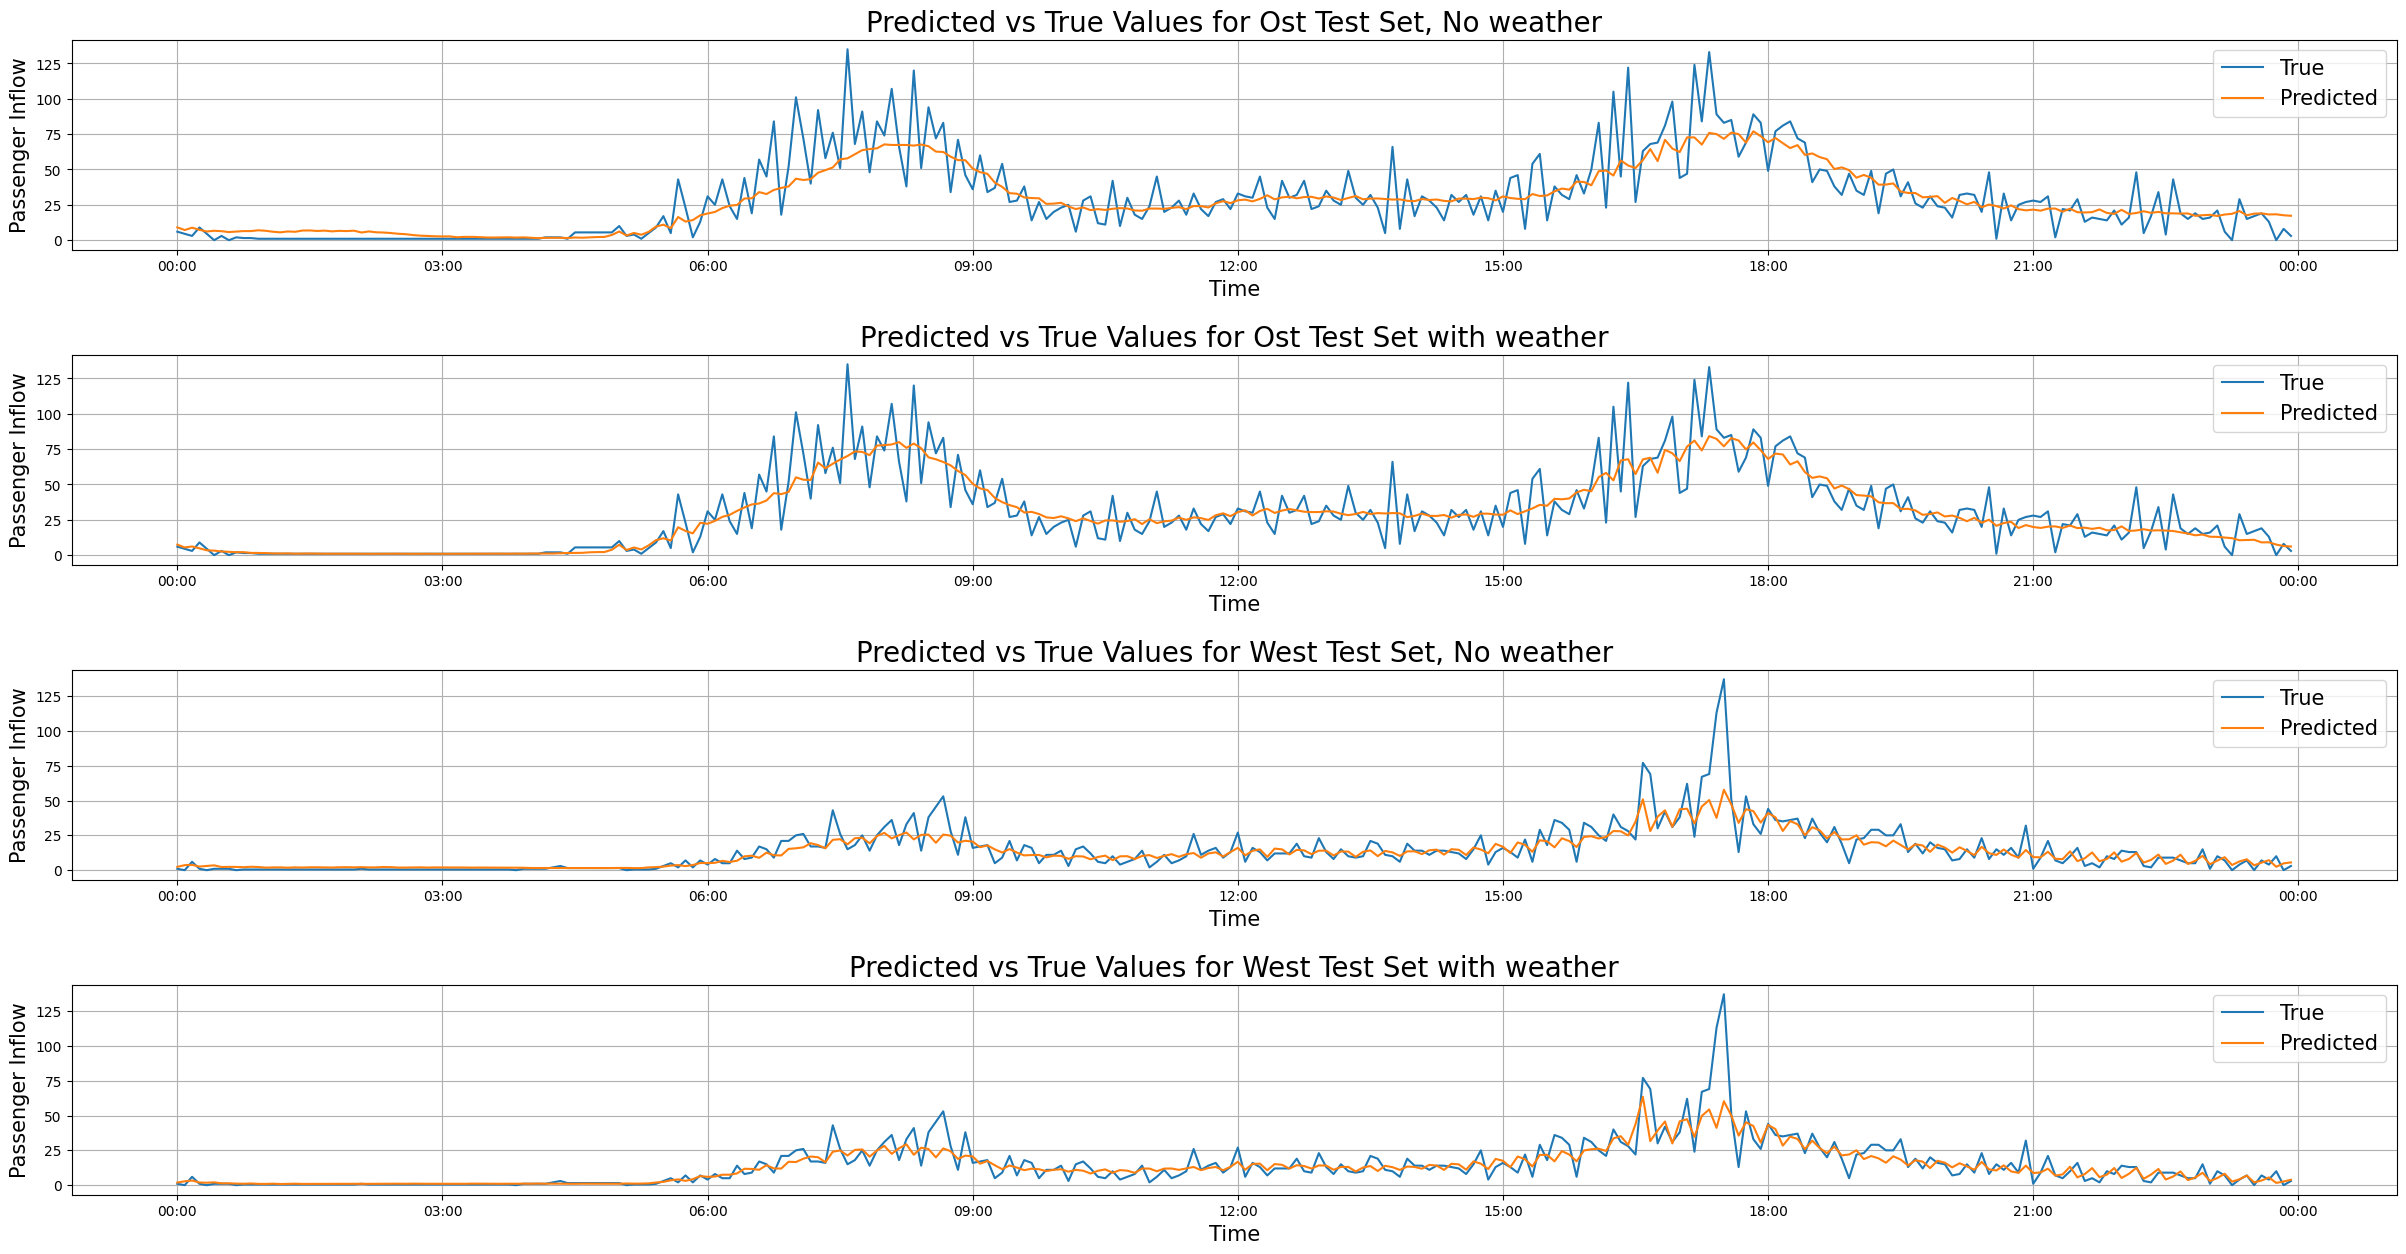

In [64]:
#Plot both west and ost
fig, axs = plt.subplots(4,1,figsize=(30, 15))

time_range = pd.date_range(start='00:00', end='23:55', freq='5min')

axs[0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
axs[0].plot(time_range, y_ost_test[0:288], label = "True")
axs[0].plot(time_range, results_test_ost, label = "Predicted")
axs[0].legend(fontsize = 15)
axs[0].set_title("Predicted vs True Values for Ost Test Set, No weather", fontsize = 20)
axs[0].set_xlabel("Time", fontsize = 15)
axs[0].set_ylabel("Passenger Inflow", fontsize = 15)
axs[0].grid(True)

axs[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
axs[1].plot(time_range, y_ost_test[0:288], label = "True")
axs[1].plot(time_range,results_test_ost1, label = "Predicted")
axs[1].legend(fontsize = 15)
axs[1].set_title("Predicted vs True Values for Ost Test Set with weather", fontsize = 20)
axs[1].set_xlabel("Time", fontsize = 15)
axs[1].set_ylabel("Passenger Inflow", fontsize = 15)
axs[1].grid(True)

axs[2].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
axs[2].plot(time_range, y_west_test[0:288], label = "True")
axs[2].plot(time_range,results_test_west, label = "Predicted")
axs[2].legend(fontsize = 15)
axs[2].set_title("Predicted vs True Values for West Test Set, No weather", fontsize = 20)
axs[2].set_xlabel("Time", fontsize = 15)
axs[2].set_ylabel("Passenger Inflow", fontsize = 15)
axs[2].grid(True)

axs[3].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
axs[3].plot(time_range, y_west_test[0:288], label = "True")
axs[3].plot(time_range,results_test_west1, label = "Predicted")
axs[3].legend(fontsize = 15)
axs[3].set_title("Predicted vs True Values for West Test Set with weather", fontsize = 20)
axs[3].set_xlabel("Time", fontsize = 15)
axs[3].set_ylabel("Passenger Inflow", fontsize = 15)
axs[3].grid(True)

plt.subplots_adjust(hspace = 0.5)
